In [52]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

# Data Exploration

In [54]:
data_raw = pd.read_csv("Offset robot.csv",skiprows=5)

## Data Explanation

Coordinates/distances are in mm, angles are in degrees.

The angles reported by our robot seem very inconsistent and we were unable to make much sense of them.

The original data is attached as a csv

In [56]:
data_raw.columns.values

array(['ccp_x', 'ccp_y', 'ccp_z', 'ccp_rx', 'ccp_ry', 'ccp_rz', 'tcp_x',
       'tcp_y', 'tcp_z', 'tcp_rx', 'tcp_ry', 'tcp_rz', 'isp_x', 'isp_y',
       'isp_z', 'isp_rx', 'isp_ry', 'isp_rz', 'fsp_x', 'fsp_y', 'fsp_z',
       'fsp_rx', 'fsp_ry', 'fsp_rz', 'ad_x', 'ad_y', 'ad_z', 'ad_rx',
       'ad_ry', 'ad_rz', 'ed_x', 'ed_y', 'ed_z', 'ed_rx', 'ed_ry',
       'ed_rz', 'os_x', 'os_y', 'os_z', 'os_rx', 'os_ry', 'os_rz'],
      dtype=object)

| data_column | description |
|----- | -- |
| ccp | initial starting location in robot base coordinates (location where image is taken)|
| tcp | ccp shifted by camera offset (from tool center point) |
| isp | in-socket-point - robot base location when plug is completely inserted in socket |
| fsp | front-of-socket-point - robot base location when plug is directly in front of socket (angles adjusted) |
| ad | actual distance between tcp and fsp |
| ed | camera/client estimate of distance |
| os | offset (ed - ad)|

#### Description of data acquisition:
- Move robot to ccp
    - take image
    - save estimated distance (ed)
    - calculate actual distance: fsp - ccp - camera offset
    - calculate offset (difference between estimate and actual distance)

#### camera offset
x = -82mm
y = 6mm
z = 55.5mm
rx = 0°
ry = 0°
rz = 0°

In [55]:
data_raw.sample(20)

,ccp_x,ccp_y,ccp_z,ccp_rx,ccp_ry,ccp_rz,tcp_x,tcp_y,tcp_z,tcp_rx,...,ed_z,ed_rx,ed_ry,ed_rz,os_x,os_y,os_z,os_rx,os_ry,os_rz
5,650.0,110.0,470.0,15.8,180.0,25.8,568.0,116.0,525.5,15.8,...,4.3,0.7,6.6,12.6,0.4,95.1,13.2,-162.2,16.0,-140.4
10,450.0,140.0,530.0,30.1,-180.0,35.1,368.0,146.0,585.5,30.1,...,-48.4,1.5,7.9,8.9,-16.3,74.5,20.5,-147.2,-342.8,-134.9
2,600.0,-80.0,500.0,163.2,180.0,158.2,518.0,-74.0,555.5,163.2,...,-27.1,0.3,8.7,-8.8,-17.2,-31.2,11.8,-15.2,18.0,-29.4
18,740.0,-150.0,430.0,158.5,180.0,143.5,658.0,-144.0,485.5,158.5,...,37.9,0.9,7.8,-14.6,6.2,-87.3,6.8,-19.3,17.2,-49.9
7,800.0,0.0,650.0,0.0,-150.0,0.0,718.0,6.0,705.5,0.0,...,-15.7,0.9,-19.6,1.1,19.1,6.2,173.3,-177.8,-340.3,-177.8
3,500.0,-180.0,700.0,0.0,160.0,-10.0,418.0,-174.0,755.5,0.0,...,-15.7,0.9,-8.6,-9.6,23.4,-99.7,223.2,-177.8,-19.3,-198.4
16,680.0,110.0,600.0,0.0,-155.0,0.0,598.0,116.0,655.5,0.0,...,58.4,1.0,-15.2,1.3,-14.3,9.2,197.3,-177.7,-340.9,-177.6
19,630.0,-250.0,500.0,148.3,180.0,128.3,548.0,-244.0,555.5,148.3,...,-29.9,0.7,9.3,-19.8,24.7,-163.0,9.0,-29.7,18.6,-70.3
13,470.0,-10.0,550.0,173.2,180.0,173.2,388.0,-4.0,605.5,173.2,...,-72.1,-0.8,9.4,-10.8,-28.8,15.3,16.8,-6.3,18.7,-16.5
4,700.0,20.0,420.0,0.2,180.0,10.2,618.0,26.0,475.5,0.2,...,51.0,0.5,6.4,10.8,-11.6,83.4,9.9,-178.0,15.7,-157.8


In [57]:
diff_df = data_raw.iloc[:,24:]
diff_df

,ad_x,ad_y,ad_z,ad_rx,ad_ry,ad_rz,ed_x,ed_y,ed_z,ed_rx,ed_ry,ed_rz,os_x,os_y,os_z,os_rx,os_ry,os_rz
0,638.5,76.9,-138.9,-1.3,0.7,8.8,631.7,-7.7,-31.0,0.5,1.8,-11.8,-6.7,-84.5,107.9,1.8,1.2,-20.7
1,688.5,6.9,-238.9,-1.3,10.7,-1.2,701.6,18.2,-10.9,1.0,-6.8,1.1,13.2,11.4,228.0,2.3,-17.4,2.2
2,588.5,56.9,-38.9,15.5,-9.3,20.7,571.3,25.7,-27.1,0.3,8.7,-8.8,-17.2,-31.2,11.8,-15.2,18.0,-29.4
3,688.5,156.9,-238.9,178.7,10.7,188.9,711.8,57.2,-15.7,0.9,-8.6,-9.6,23.4,-99.7,223.2,-177.8,-19.3,-198.4
4,488.5,-43.1,41.1,178.5,-9.3,168.6,476.9,40.3,51.0,0.5,6.4,10.8,-11.6,83.4,9.9,-178.0,15.7,-157.8
5,538.5,-133.1,-8.9,162.9,-9.3,153.1,538.9,-38.0,4.3,0.7,6.6,12.6,0.4,95.1,13.2,-162.2,16.0,-140.4
6,738.5,-73.1,-88.9,163.9,-9.3,164.1,709.8,-56.4,-71.4,1.3,7.2,4.4,-28.6,16.7,17.6,-162.6,16.5,-159.7
7,388.5,-23.1,-188.9,178.7,320.7,178.9,407.5,-16.9,-15.7,0.9,-19.6,1.1,19.1,6.2,173.3,-177.8,-340.3,-177.8
8,438.5,-93.1,-158.9,178.7,330.7,168.9,453.4,-21.4,-24.4,0.8,-10.1,11.7,14.9,71.7,134.5,-177.9,-340.8,-157.1
9,788.5,-13.1,-118.9,178.7,345.7,178.9,760.4,2.7,-40.4,-0.2,7.4,-10.3,-28.1,15.8,78.5,-178.9,-338.3,-189.1


Text(0.5, 1.0, 'Correlation heatmap')

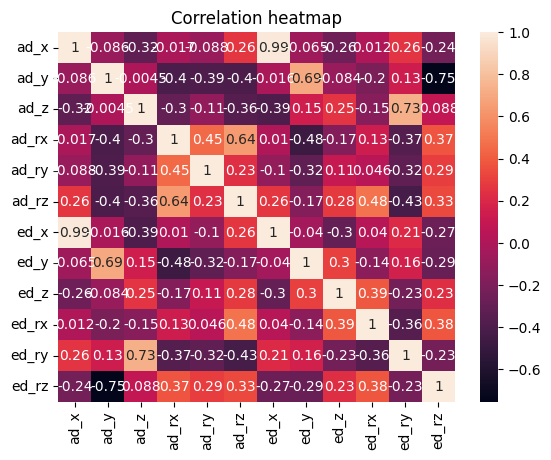

In [61]:
sns.heatmap(diff_df.iloc[:,:12].corr(),annot=True).set_title("Correlation heatmap")

## Multiple Linear Regression

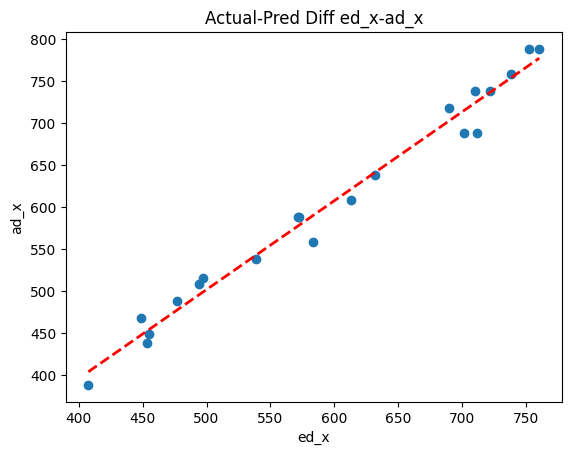

Regression Analysis for ed_x-ad_x:
R_squared:  0.98
p-score:  0.0


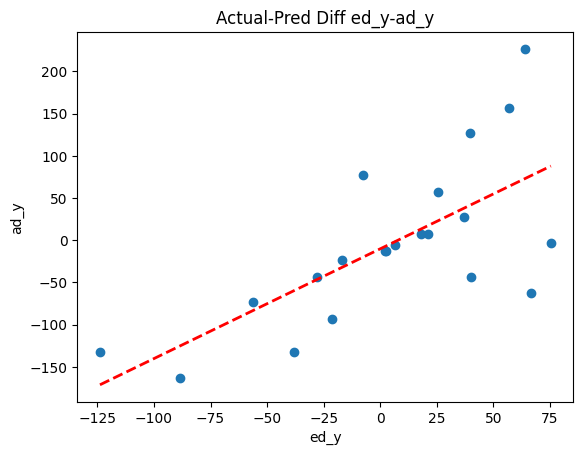

Regression Analysis for ed_y-ad_y:
R_squared:  0.48
p-score:  0.0005


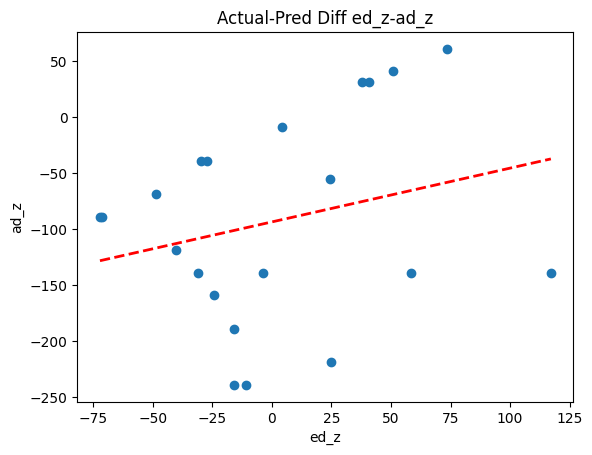

Regression Analysis for ed_z-ad_z:
R_squared:  0.07
p-score:  0.2647


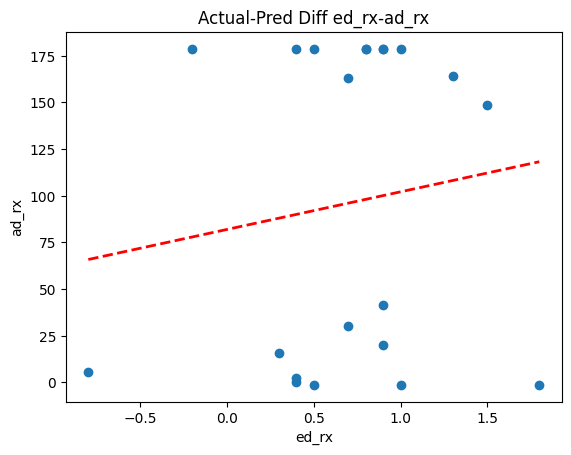

Regression Analysis for ed_rx-ad_rx:
R_squared:  0.02
p-score:  0.5652


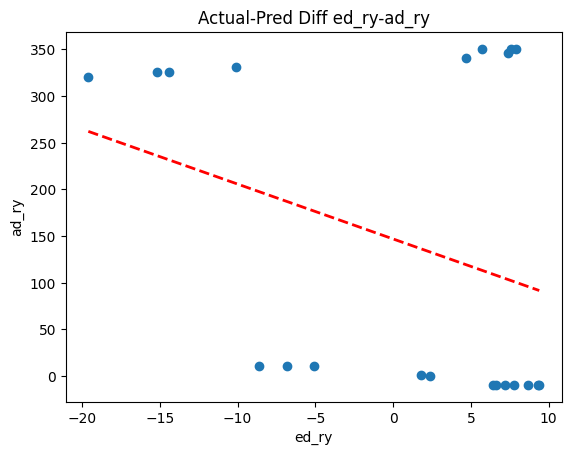

Regression Analysis for ed_ry-ad_ry:
R_squared:  0.1
p-score:  0.1604


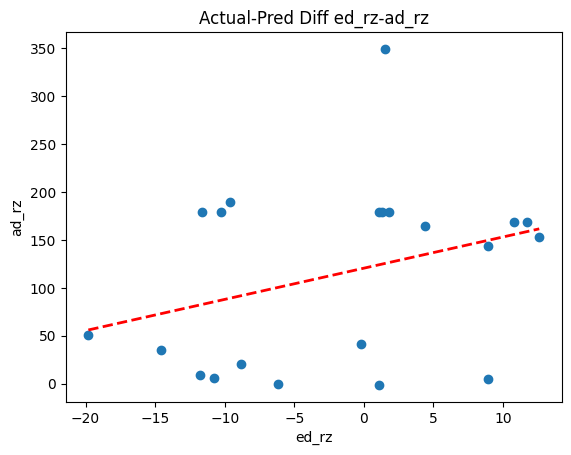

Regression Analysis for ed_rz-ad_rz:
R_squared:  0.11
p-score:  0.1436


In [59]:
diff_name_list = [["ad_x", "ed_x"], ["ad_y", "ed_y"], ["ad_z", "ed_z"], ["ad_rx","ed_rx"],["ad_ry","ed_ry"],["ad_rz","ed_rz"]]

degree = 1  # Degree of the polynomial features

for y, x in diff_name_list:
    X = diff_df[x].values.reshape(-1, 1)  # Predictor variable
    Y = diff_df[y]  # Response variable
    
    # Generate polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X)
    
    # Perform polynomial regression using statsmodels
    sm_model = sm.OLS(Y, X_poly)
    sm_results = sm_model.fit()
    
    # Predict using the polynomial regression model
    y_pred = sm_results.predict(X_poly)
    
    # Plot the data and the polynomial regression curve
    plt.scatter(X, Y)
    plt.title(f"Actual-Pred Diff {x}-{y}")
    plt.xlabel(x)
    plt.ylabel(y)
    
    # Sort the x values for better visualization
    sorted_indices = np.argsort(X, axis=0)
    x_sorted = X[sorted_indices].reshape(-1, 1)
    y_pred_sorted = y_pred[sorted_indices].reshape(-1, 1)
    
    # Plot the regression line
    plt.plot(x_sorted, y_pred_sorted, '--', color='red', linewidth=2)
    plt.show()
    
    # Print summary of regression analysis
    print(f"Regression Analysis for {x}-{y}:")
    print(f"R_squared: ",round(sm_results.rsquared,2))
    print(f"p-score: ",round(sm_results.f_pvalue,4))